In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
df_msg = pd.read_csv('messages.db.csv')
df_msg

,conversationid,user1,user2,rank,inverse.rank,timestamp,mess.sentim,message.id,message.type,sender.id,reader.id,N.words
0,1,1,2759.0,1,14,17320,3,1,aff.nor,1.0,2759.0,41
1,1,1,2759.0,2,13,17320,1,2,chunk,2759.0,1.0,43
2,1,1,2759.0,3,12,17320,-3,3,aff.nor,2759.0,1.0,26
3,1,1,2759.0,4,11,17320,-2,4,questn,2759.0,1.0,2
4,1,1,2759.0,5,10,17320,-1,5,aff.nor,1.0,2759.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...
388403,25048,1500,2314.0,6,5,17199,-3,388404,aff.nor,2314.0,1500.0,18
388404,25048,1500,2314.0,7,4,17200,2,388405,aff.nor,1500.0,2314.0,37
388405,25048,1500,2314.0,8,3,17201,2,388406,aff.nor,2314.0,1500.0,9
388406,25048,1500,2314.0,9,2,17201,-3,388407,chunk,2314.0,1500.0,49


Let's see how many different conversations we are working with.

In [3]:
unique_convos = df_msg['conversationid'].unique()
len(unique_convos)

25036

In [4]:
df_msg[df_msg['conversationid'] == unique_convos[0]]

,conversationid,user1,user2,rank,inverse.rank,timestamp,mess.sentim,message.id,message.type,sender.id,reader.id,N.words
0,1,1,2759.0,1,14,17320,3,1,aff.nor,1.0,2759.0,41
1,1,1,2759.0,2,13,17320,1,2,chunk,2759.0,1.0,43
2,1,1,2759.0,3,12,17320,-3,3,aff.nor,2759.0,1.0,26
3,1,1,2759.0,4,11,17320,-2,4,questn,2759.0,1.0,2
4,1,1,2759.0,5,10,17320,-1,5,aff.nor,1.0,2759.0,23
5,1,1,2759.0,6,9,17320,-3,6,questn,2759.0,1.0,18
6,1,1,2759.0,7,8,17320,-1,7,aff.nor,2759.0,1.0,37
7,1,1,2759.0,8,7,17320,4,8,aff.nor,1.0,2759.0,44
8,1,1,2759.0,9,6,17320,-3,9,aff.nor,1.0,2759.0,25
9,1,1,2759.0,10,5,17320,7,10,chunk,2759.0,1.0,48


We create a new DataFrame which is the product of grouping by our original dataset based on the individual conversations while also applying the correct format to the data for the n-gram search that will be performed.

In [5]:
msg_grouped = df_msg.groupby('conversationid')['message.type'].apply(lambda x: ' '.join(x))
msg_grouped

conversationid
1        aff.nor chunk aff.nor questn aff.nor questn af...
2        aff.nor aff.nor aff.nor aff.nor aff.nor aff.no...
3        questn aff.nor questn aff.nor aff.nor aff.nor ...
4        aff.nor aff.nor aff.nor questn questn aff.nor ...
5              aff.nor aff.nor aff.off aff.off aff.off end
                               ...                        
25044    aff.nor aff.nor aff.nor questn questn piss.off...
25045    questn aff.nor aff.nor aff.nor aff.nor aff.nor...
25046    aff.nor chunk questn questn questn questn aff....
25047    aff.nor aff.nor aff.nor chunk questn aff.nor q...
25048    aff.nor aff.nor aff.nor aff.nor aff.nor aff.no...
Name: message.type, Length: 25036, dtype: object

Now we finalize our DataFrame that has a column of the conversation as a list of the elements of *message.type* in the order that they appear, while the index represents the conversation_id

In [6]:
msg_grouped = pd.DataFrame({
    'conversation': msg_grouped.values
})
msg_grouped

,conversation
0,aff.nor chunk aff.nor questn aff.nor questn af...
1,aff.nor aff.nor aff.nor aff.nor aff.nor aff.no...
2,questn aff.nor questn aff.nor aff.nor aff.nor ...
3,aff.nor aff.nor aff.nor questn questn aff.nor ...
4,aff.nor aff.nor aff.off aff.off aff.off end
...,...
25031,aff.nor aff.nor aff.nor questn questn piss.off...
25032,questn aff.nor aff.nor aff.nor aff.nor aff.nor...
25033,aff.nor chunk questn questn questn questn aff....
25034,aff.nor aff.nor aff.nor chunk questn aff.nor q...


Here we define a function that removes the dots and concatenates the two words that were seperated by it:

In [7]:
def preprocess_sequence(sequence):
    words = sequence.replace('.', '').split()
    return ' '.join(words)

msg_grouped['conversation'] = msg_grouped['conversation'].apply(lambda x: preprocess_sequence(x))
msg_grouped

,conversation
0,affnor chunk affnor questn affnor questn affno...
1,affnor affnor affnor affnor affnor affnor affn...
2,questn affnor questn affnor affnor affnor affn...
3,affnor affnor affnor questn questn affnor affn...
4,affnor affnor affoff affoff affoff end
...,...
25031,affnor affnor affnor questn questn pissoff aff...
25032,questn affnor affnor affnor affnor affnor affn...
25033,affnor chunk questn questn questn questn affno...
25034,affnor affnor affnor chunk questn affnor quest...


Lets take a look of what a conversation looks like, to familiarize with the data.

In [8]:
msg_grouped.at[0, 'conversation']

'affnor chunk affnor questn affnor questn affnor affnor affnor chunk questn affnor affnor end'

We create our n-gram vectorizer and create a new dataframe, *trigram_df*, where its column is a trigram detected in the whole corpus, each row represents a different conversation based on the conversation_id and the value of each cell indicates the number of times said trigram exists in said conversation

In [9]:
vectorizer = CountVectorizer(ngram_range=(3, 3))
trigrams = vectorizer.fit_transform(msg_grouped['conversation'])
trigram_df = pd.DataFrame(trigrams.toarray(), columns=vectorizer.get_feature_names())
trigram_df

c:\Users\alexf\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,affnor affnor affnor,affnor affnor affoff,affnor affnor chunk,affnor affnor end,affnor affnor phone,affnor affnor pissoff,affnor affnor questn,affnor affoff affoff,affnor chunk affnor,affnor chunk affoff,...,questn pissoff phone,questn pissoff pissoff,questn pissoff questn,questn questn affnor,questn questn affoff,questn questn chunk,questn questn end,questn questn phone,questn questn pissoff,questn questn questn
0,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,2,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,1,0,0,0,2,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25031,1,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
25032,6,0,0,0,0,0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
25033,0,0,1,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,2
25034,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In order to access the trigram's frequency we will use the following three metrics:
1. Count: Simply add up the number of times each trigram appears

2. Term Frequency: Exactly like count but we normalize based on the total number of trigrams in each sequence

3. Inverse Document Frequency: The ratio of the number of conversations and the number of conversations containing a trigram. 

Lets tackle the simplest one, addition.

In [10]:
trigram_counts = trigram_df.sum(axis=0)
trigram_counts = pd.DataFrame({
    'trigram' : trigram_df.columns,
    'count' : trigram_counts.to_list()})
trigram_counts.sort_values(by='count', ascending=False, inplace=True)
trigram_counts.reset_index(inplace=True)
trigram_counts.drop(columns='index', inplace=True)
trigram_counts



,trigram,count
0,affnor affnor affnor,77124
1,affnor affnor questn,26759
2,questn affnor affnor,25593
3,affnor questn affnor,25529
4,affnor affnor chunk,15345
...,...,...
114,chunk pissoff affoff,6
115,pissoff pissoff end,5
116,pissoff chunk phone,5
117,pissoff pissoff phone,2


Now let's try the term frequenct metric (TF)

We will have to compute:
1. The the total number of trigrams in each sequence
2. The count of each trigram in each sequence

Then we will divide those two values for each trigram and get it's term frequency.

In [11]:
trigrams_per_conv = trigram_df.sum(axis=1)
trigrams_per_conv

0        12
1        11
2        21
3        20
4         4
         ..
25031    11
25032    20
25033    17
25034    13
25035     8
Length: 25036, dtype: int64

In [12]:
term_frequency = trigram_df / trigrams_per_conv[:, None]
term_frequency


C:\Users\alexf\AppData\Local\Temp\ipykernel_14996\468850265.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  term_frequency = trigram_df / trigrams_per_conv[:, None]


,affnor affnor affnor,affnor affnor affoff,affnor affnor chunk,affnor affnor end,affnor affnor phone,affnor affnor pissoff,affnor affnor questn,affnor affoff affoff,affnor chunk affnor,affnor chunk affoff,...,questn pissoff phone,questn pissoff pissoff,questn pissoff questn,questn questn affnor,questn questn affoff,questn questn chunk,questn questn end,questn questn phone,questn questn pissoff,questn questn questn
0,0.083333,0.00,0.083333,0.083333,0.0,0.0,0.000000,0.00,0.083333,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.454545,0.00,0.090909,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.238095,0.00,0.095238,0.000000,0.0,0.0,0.047619,0.00,0.047619,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.250000,0.00,0.050000,0.000000,0.0,0.0,0.100000,0.00,0.050000,0.0,...,0.0,0.0,0.0,0.050000,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.25,0.000000,0.000000,0.0,0.0,0.000000,0.25,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25031,0.090909,0.00,0.000000,0.000000,0.0,0.0,0.181818,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.090909,0.000000
25032,0.300000,0.00,0.000000,0.000000,0.0,0.0,0.100000,0.00,0.050000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
25033,0.000000,0.00,0.058824,0.058824,0.0,0.0,0.058824,0.00,0.058824,0.0,...,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,0.000000,0.117647
25034,0.076923,0.00,0.076923,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.000000,0.000000


In [13]:
tf_freq = term_frequency.sum(axis=0)
tf_freq

affnor affnor affnor     5170.273720
affnor affnor affoff      123.901258
affnor affnor chunk      1091.022553
affnor affnor end         448.220698
affnor affnor phone       145.025505
                            ...     
questn questn chunk       119.158544
questn questn end         371.757976
questn questn phone        19.497091
questn questn pissoff      22.517388
questn questn questn      596.197698
Length: 119, dtype: float64

In [14]:
tf_freq = pd.DataFrame({
    'trigram': tf_freq.index,
    'tf_count': tf_freq.values
})
tf_freq['tf_count'] = tf_freq['tf_count'].apply(lambda x: round(x, 2))
tf_freq = tf_freq.sort_values(by='tf_count', ascending=False).reset_index()
tf_freq.drop(columns='index', inplace=True)
tf_freq

,trigram,tf_count
0,affnor affnor affnor,5170.27
1,affnor affnor questn,1823.80
2,questn affnor affnor,1717.70
3,affnor questn affnor,1714.63
4,affnor affnor chunk,1091.02
...,...,...
114,pissoff pissoff chunk,0.75
115,pissoff chunk phone,0.62
116,chunk pissoff affoff,0.60
117,pissoff pissoff phone,0.39


Now we will tackle the inverse term frequenct (IDF)

In [15]:
tfidf = TfidfVectorizer(ngram_range=(3,3))
tfidf.fit_transform(msg_grouped['conversation'])
idf_df = pd.DataFrame({
    'trigram' : tfidf.get_feature_names_out(),
    'idf' : tfidf.idf_
})
idf_df.sort_values(by='idf', ascending=True, inplace=True)
idf_df['idf'] = idf_df['idf'].apply(lambda x: round(x, 3))
idf_df

,trigram,idf
0,affnor affnor affnor,1.270
6,affnor affnor questn,1.420
90,questn affnor affnor,1.456
22,affnor questn affnor,1.532
2,affnor affnor chunk,1.766
...,...,...
49,chunk pissoff affoff,9.182
80,pissoff pissoff end,9.336
74,pissoff chunk phone,9.336
81,pissoff pissoff phone,10.029


Now that we are done using all three metrics, let's visualize the top 30 trigrams from each metric and evaluate the results.

In [16]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

fig = make_subplots(rows=1, cols=3, 
                    subplot_titles=('Count', 
                                    'Term Frequency (TF)', 
                                    'Inverse Term Frequency (IDF)'))

fig.add_trace(go.Bar(x=trigram_counts.head(30)['trigram'], 
                     y=trigram_counts.head(30)['count'], 
                     name='Count'), row=1, col=1)
fig.update_xaxes(title_text='Trigrams', row=1, col=1, tickangle=45)
fig.update_yaxes(title_text='Times Trigram Appears', row=1, col=1)

fig.add_trace(go.Bar(x=tf_freq.head(30)['trigram'], 
                     y=tf_freq.head(30)['tf_count'], 
                     name='Term Frequency'), row=1, col=2)
fig.update_xaxes(title_text='Trigrams', row=1, col=2, tickangle=45)
fig.update_yaxes(title_text='Trigram Term Frequency', row=1, col=2)

fig.add_trace(go.Bar(x=idf_df.head(30)['trigram'], 
                     y=idf_df.head(30)['idf'], 
                     name='Inverse Term Frequency'), row=1, col=3)
fig.update_xaxes(title_text='Trigrams', row=1, col=3, tickangle=45)
fig.update_yaxes(title_text='Inverse Term Frequency', row=1, col=3)

fig.update_layout(showlegend=False, width=1000, height=500, title_text="30 Most Frequent Trigrams")
fig.show()


Now we will create a table with each trigram and its score on each metric as well as its appearance percent with respect to all other trigrams

Firstly, we reset the indexes and put all the unique trigrams into a list.

In [17]:
idf_df.reset_index(inplace=True)
idf_df.drop(columns='index', inplace=True)
idf_df

,trigram,idf
0,affnor affnor affnor,1.270
1,affnor affnor questn,1.420
2,questn affnor affnor,1.456
3,affnor questn affnor,1.532
4,affnor affnor chunk,1.766
...,...,...
114,chunk pissoff affoff,9.182
115,pissoff pissoff end,9.336
116,pissoff chunk phone,9.336
117,pissoff pissoff phone,10.029


In [18]:
trigrams = idf_df['trigram'].unique().tolist()
trigrams

['affnor affnor affnor',
 'affnor affnor questn',
 'questn affnor affnor',
 'affnor questn affnor',
 'affnor affnor chunk',
 'chunk affnor affnor',
 'affnor chunk affnor',
 'affnor questn questn',
 'questn questn affnor',
 'questn affnor questn',
 'affnor chunk chunk',
 'questn questn questn',
 'affnor questn chunk',
 'questn affnor chunk',
 'chunk affnor questn',
 'affnor chunk questn',
 'questn chunk affnor',
 'chunk questn affnor',
 'affnor affnor end',
 'chunk chunk questn',
 'chunk chunk chunk',
 'questn questn end',
 'chunk questn end',
 'affoff affoff affoff',
 'chunk chunk end',
 'affnor affnor pissoff',
 'pissoff affnor affnor',
 'affnor pissoff affnor',
 'chunk affnor chunk',
 'questn chunk chunk',
 'affnor affoff affoff',
 'chunk chunk affnor',
 'affoff affoff end',
 'chunk questn questn',
 'questn questn chunk',
 'questn chunk questn',
 'affoff affoff pissoff',
 'affnor affnor affoff',
 'affnor questn end',
 'questn affnor end',
 'affnor affnor phone',
 'questn affnor pisso

We create our DataFrame that will represent our table.

In [19]:
final_table = pd.DataFrame(index=idf_df.index, columns=('Trigram', 'Count', 'Term Frequency', 'Inverse Document Frequency', 'Percentage'))
final_table

,Trigram,Count,Term Frequency,Inverse Document Frequency,Percentage
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
114,NaN,NaN,NaN,NaN,NaN
115,NaN,NaN,NaN,NaN,NaN
116,NaN,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN,NaN


We fill in the values.

In [20]:
final_table['Trigram'] = trigrams
final_table

,Trigram,Count,Term Frequency,Inverse Document Frequency,Percentage
0,affnor affnor affnor,NaN,NaN,NaN,NaN
1,affnor affnor questn,NaN,NaN,NaN,NaN
2,questn affnor affnor,NaN,NaN,NaN,NaN
3,affnor questn affnor,NaN,NaN,NaN,NaN
4,affnor affnor chunk,NaN,NaN,NaN,NaN
...,...,...,...,...,...
114,chunk pissoff affoff,NaN,NaN,NaN,NaN
115,pissoff pissoff end,NaN,NaN,NaN,NaN
116,pissoff chunk phone,NaN,NaN,NaN,NaN
117,pissoff pissoff phone,NaN,NaN,NaN,NaN


In [21]:
trigrams_present = trigram_counts['count'].sum()
for index in final_table.index:
        final_table.at[index, 'Count'] = trigram_counts.loc[trigram_counts['trigram'] == final_table.at[index, 'Trigram'], 'count'].values[0]
        final_table.at[index, 'Term Frequency'] = tf_freq.loc[tf_freq['trigram'] == final_table.at[index, 'Trigram'], 'tf_count'].values[0]
        final_table.at[index, 'Inverse Document Frequency'] = idf_df.loc[idf_df['trigram'] == final_table.at[index, 'Trigram'], 'idf'].values[0]
        final_table.at[index, 'Percentage'] = round((final_table.at[index, 'Count'] / trigrams_present) * 100)

final_table.sort_values(by='Inverse Document Frequency', ascending=True, inplace=True)
final_table.head(25)

,Trigram,Count,Term Frequency,Inverse Document Frequency,Percentage
0,affnor affnor affnor,77124,5170.27,1.27,23
1,affnor affnor questn,26759,1823.8,1.42,8
2,questn affnor affnor,25593,1717.7,1.456,8
3,affnor questn affnor,25529,1714.63,1.532,8
4,affnor affnor chunk,15345,1091.02,1.766,5
5,chunk affnor affnor,12830,867.12,1.922,4
6,affnor chunk affnor,12796,856.17,1.973,4
7,affnor questn questn,10980,807.41,2.022,3
8,questn questn affnor,8605,575.72,2.243,3
9,questn affnor questn,8966,608.8,2.303,3


What we can deduct from this table, is that all three metrics were pretty close to identifying the most frequent trigrams, however the inverse document metric is the more robust since it takes into consideration the population of the corpus.

In this section we will uncover how do conversations end by focusing on the last six messages of each conversation.

Firstly we create a new column that has the sequence of the last 6 messages as a list

In [22]:
msg_grouped['last_6_mess'] = msg_grouped['conversation'].apply(lambda x: x.split()[-6:])
msg_grouped

,conversation,last_6_mess
0,affnor chunk affnor questn affnor questn affno...,"[affnor, chunk, questn, affnor, affnor, end]"
1,affnor affnor affnor affnor affnor affnor affn...,"[chunk, questn, chunk, affnor, questn, end]"
2,questn affnor questn affnor affnor affnor affn...,"[affnor, affnor, chunk, affnor, questn, phone]"
3,affnor affnor affnor questn questn affnor affn...,"[chunk, affnor, chunk, chunk, questn, end]"
4,affnor affnor affoff affoff affoff end,"[affnor, affnor, affoff, affoff, affoff, end]"
...,...,...
25031,affnor affnor affnor questn questn pissoff aff...,"[affnor, questn, affnor, questn, affnor, end]"
25032,questn affnor affnor affnor affnor affnor affn...,"[chunk, affnor, questn, affnor, questn, phone]"
25033,affnor chunk questn questn questn questn affno...,"[affnor, affnor, chunk, affnor, affnor, end]"
25034,affnor affnor affnor chunk questn affnor quest...,"[questn, affnor, questn, affnor, pissoff, end]"


We extract the unique types of messages

In [23]:
elements = list(set([item for sublist in msg_grouped['last_6_mess'] for item in sublist]))
elements

['affnor', 'questn', 'chunk', 'end', 'phone', 'affoff', 'pissoff']

We create our pivot table, where the indexes are indicative of the conversation, each column represents the message order of the sequence and the cells have the index value of said message type from the *elements* list.

In [24]:
pivot = pd.DataFrame(index=msg_grouped.index, columns=['1', '2', '3', '4', '5', '6'])
pivot

,1,2,3,4,5,6
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
25031,NaN,NaN,NaN,NaN,NaN,NaN
25032,NaN,NaN,NaN,NaN,NaN,NaN
25033,NaN,NaN,NaN,NaN,NaN,NaN
25034,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
event_dict = {'phone' : 0.0, 'affnor' : 1.0, 'pissoff' : 2.0, 'end' : 3.0, 'chunk' : 4.0, 
              'affoff' : 5.0, 'questn' : 6.0}

for index in msg_grouped.index:
    for i in range(len(msg_grouped['last_6_mess'][index])):
        pivot.at[index,  f'{i + 1}'] = event_dict[(msg_grouped['last_6_mess'][index][i])]
pivot = pivot.astype(float)
pivot

,1,2,3,4,5,6
0,1.0,4.0,6.0,1.0,1.0,3.0
1,4.0,6.0,4.0,1.0,6.0,3.0
2,1.0,1.0,4.0,1.0,6.0,0.0
3,4.0,1.0,4.0,4.0,6.0,3.0
4,1.0,1.0,5.0,5.0,5.0,3.0
...,...,...,...,...,...,...
25031,1.0,6.0,1.0,6.0,1.0,3.0
25032,4.0,1.0,6.0,1.0,6.0,0.0
25033,1.0,1.0,4.0,1.0,1.0,3.0
25034,6.0,1.0,6.0,1.0,2.0,3.0


We create the heatmap.

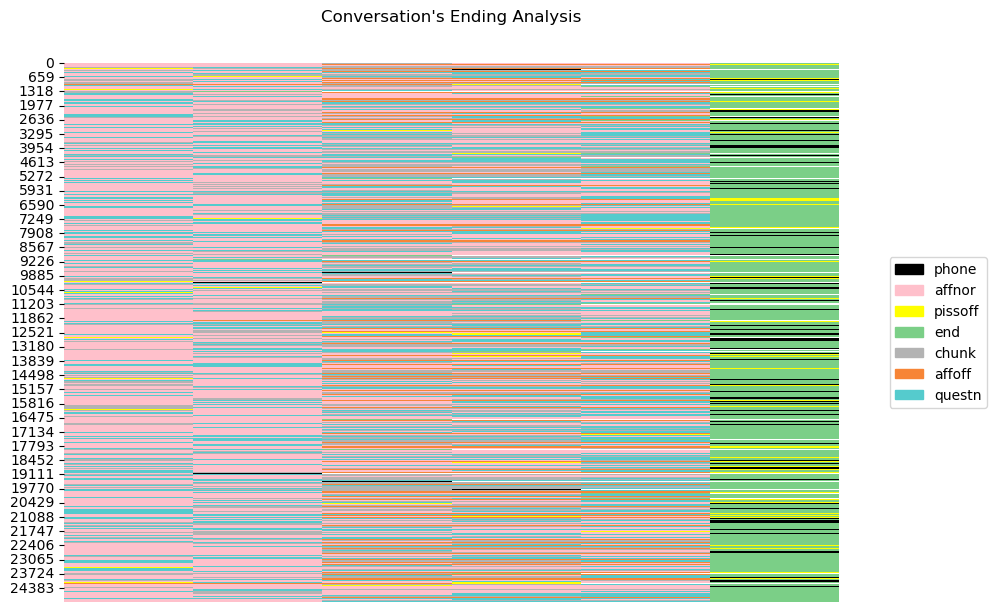

In [33]:
plt.figure(figsize=(10, 7))

color_dict = {0.0: '#000000', 1.0: 'pink', 2.0 : 'yellow',
              3.0: '#7bcf87', 4.0: '#B3B3B3', 5.0: '#f78536', 6.0: '#55CBCD'}

custom_cmap = ListedColormap([color_dict[x] for x in color_dict])

ax = sns.heatmap(pivot, cmap=custom_cmap, cbar=False, xticklabels=False)

handles = [plt.Rectangle((0, 0), 1, 1, color=color_dict[i]) for i in color_dict]
labels = [key for key in event_dict.keys()]
plt.legend(handles, labels, bbox_to_anchor=(1.2, 0.5), loc='center right')
plt.title("Conversation's Ending Analysis", pad=30)
plt.show()